# Spatiotemporal Distribution of Dams

In [1]:
from __future__ import annotations

import shutil
from pathlib import Path

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
from matplotlib.font_manager import fontManager
from tqdm.auto import tqdm

import pygeohydro as gh

Get the data from the [National Inventory of Dams](https://damsdev.net) using [PyGeoHydro](https://github.com/cheginit/pygeohydro) package within contiguous US. Note that since we want to get all dams within CONUS it's much more efficient to "stage" the latest version of the entire NID database by calling `NID().stage_nid_inventory()`. This function downloads the entire NID dataset and saves it as a feather file.

In [2]:
nid = gh.NID()
nid.stage_nid_inventory()

dams = gpd.read_feather(nid.nid_inventory_path)
conus_geom = gh.helpers.get_us_states("contiguous").to_crs(dams.crs)
conus_dams = dams[dams.stateKey.isin(conus_geom.STUSPS)].reset_index(drop=True)

Since we're going to use dam coordinates and completion year to filter the data, let's check number of missing data to find the total available dams that include these two data.

In [3]:
missing = ~(conus_dams.is_valid).sum() + conus_dams.yearCompleted.isna().sum()
conus_dams.shape[0] - missing

165251

Let's plot the number of missing data by state.

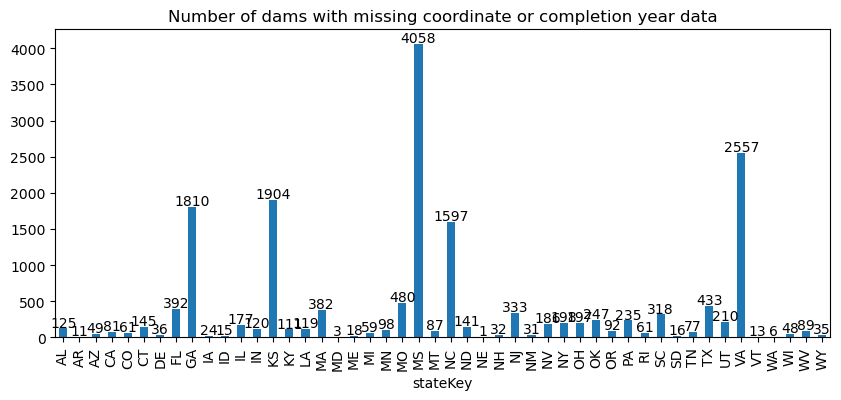

In [4]:
ax = (
    conus_dams[~conus_dams.is_valid | conus_dams.yearCompleted.isna()]
    .groupby("stateKey")
    .size()
    .plot.bar(figsize=(10, 4))
)
ax.set_title("Number of dams with missing coordinate or completion year data")

for p in ax.patches:
    ax.annotate(
        p.get_height(),
        (p.get_x() + p.get_width() / 2, p.get_height() + 80),
        ha="center",
        va="center",
    )

Plot the frames.

In [5]:
column = "damHeight"
cmap = "viridis"
min_q, max_q = 0.1, 0.9

conus_dams = conus_dams[conus_dams.is_valid & (conus_dams.yearCompleted > 0)]

label = nid.fields_meta[nid.fields_meta["name"] == column].label.iloc[0]
label = "\n".join([label, f"{min_q} - {max_q} Quantile"])
norm = plt.Normalize(
    vmin=conus_dams[column].quantile(min_q), vmax=conus_dams[column].quantile(max_q)
)

dpi = 300.0
figsize = (1920.0 / dpi, 1080.0 / dpi)
font = "Lato"
indent = "\n        "
if font in {f.name for f in fontManager.ttflist}:
    matplotlib.rcParams["font.sans-serif"] = font
    matplotlib.rcParams["font.family"] = "sans-serif"
plt.ioff()

root = Path("tmp")
shutil.rmtree(root, ignore_errors=True)
root.mkdir(exist_ok=True)

conus_geom = conus_geom.to_crs(5070)
conus_dams = conus_dams.to_crs(5070)


def get_ax():
    ax = conus_geom.plot(figsize=figsize, facecolor="none", edgecolor="k", lw=0.2, alpha=0.5)
    ax.axis(False)
    fig = ax.figure
    fig.set_dpi(dpi)
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, cax=cax, label=label)
    return ax


yr_min = conus_dams.yearCompleted.astype("Int32").min()
yr_max = conus_dams.yearCompleted.astype("Int32").max()
years = range(yr_min + 1, yr_max + 1)
with tqdm(total=len(years), desc="Plotting") as pbar:
    for year in years:
        pbar.set_postfix_str(f"Year: {year}")
        dams = conus_dams[conus_dams.yearCompleted <= year]
        ax = get_ax()
        dams.plot(
            ax=ax,
            column=column,
            cmap=cmap,
            norm=norm,
            alpha=0.3,
            markersize=3,
        )
        ax.set_title(f"Dams Completed Up to {year}\nTotal = {len(dams):,}")
        h_max = dams[column].max()
        name_max = dams.iloc[dams[column].argmax()]["name"].title()
        ax.annotate(
            f"Largest Dam:{indent}Height: {h_max:.1f} ft{indent}Name: {name_max}",
            xy=(0, 0),
            xycoords=ax.transAxes,
        )
        ax.figure.savefig(Path(root, f"{year}.png"), bbox_inches="tight", dpi=dpi, facecolor="w")
        plt.close("all")
        pbar.update(1)

Plotting:   0%|          | 0/8359 [00:00<?, ?it/s]

Repeat the last frame 100 times.

In [ ]:
for i in range(1, 100):
    shutil.copy(Path("tmp", f"{years[-1]}.png"), Path("tmp", f"{years[-1] + i}.png"))
_ = shutil.copy(Path("tmp", "2022.png"), Path("_static", "nid_2022.png"))

PosixPath('_static/nid_2022.png')

Convert the frames to a video file.

In [ ]:
!ffmpeg -hide_banner -loglevel panic -start_number 1641 -i tmp/%04d.png -pix_fmt yuv420p -vf scale=1920:-2 -y input_data/NID_2022.mp4

You can check out the video here:

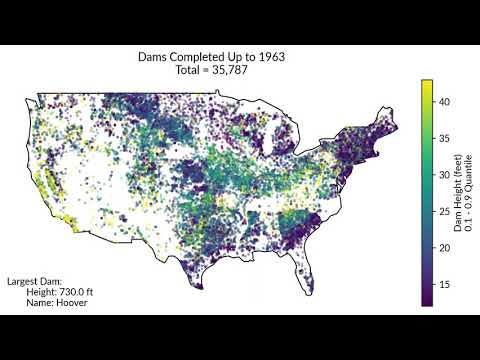

In [ ]:
YouTubeVideo("AM2f9MaBjiQ")